In [ ]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# hv.renderer('bokeh').theme = 'dark_minimal'

In [2]:
# dataset_root = Path(r"C:\Users\Raffael\Documents\Datasets\alpiq_2023") # Raw string works without escaping \
dataset_root = Path(r"C:/Users/jadbh\Documents/Swisse/EPFL/courses/Fall 2024/Machine Learning for Predictive Maintenance/project/Dataset")
dataset_root = Path(r"C:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\project\team repo\Machine-Learning-for-Predictive-Maintenance-project\Dataset")


@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True)

In [3]:
vg5_train_meas = rds_u5.data_dict["train"].measurements
vg5_train_info = rds_u5.data_dict["train"].info
vg5_test_meas = rds_u5.data_dict["test"].measurements
vg5_test_info = rds_u5.data_dict["test"].info

In [4]:
vg5_train_filt = vg5_train_meas [ (vg5_train_meas['equilibrium_turbine_mode'] == True) |
                                           ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                           ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

In [5]:
vg5_s1 = rds_u5.data_dict["test_s01"].measurements          # synthetic testing
vg5_s1_filt = vg5_s1 [ (vg5_s1['equilibrium_turbine_mode'] == True) |        # filtered synthetic testing
                    ((vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['short_circuit_mode'] == False)) |
                    ((vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['short_circuit_mode'] == True) & (vg5_s1['equilibrium_short_circuit_mode'] == True)) ]

In [6]:
vg5_train_meas.reset_index(inplace=True)
vg5_train_filt = vg5_train_meas [ (vg5_train_meas['equilibrium_turbine_mode'] == True) |
                                           ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                           ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

In [7]:
# summary of VG5 useful variables

vg5_train_info
vg5_train_filt      # equilibirum
vg5_train_meas

vg5_test_info
vg5_test_meas

vg5_s1
vg5_s1_filt         # equilibrium

print()

In [8]:
df = vg5_train_filt
print(df.columns)
df.head(3)

Index(['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge',
       'coupler_position', 'injector_01_opening', 'injector_02_opening',
       'injector_03_opening', 'injector_04_opening', 'injector_05_opening',
       'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed',
       'tot_current', 'tot_effectivepower', 'tot_reactivepower',
       'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening',
       'water_primary_pump_02_opening', 'air_circ_cold_01_tmp',
       'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp',
       'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp',
       'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp',
       'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq',
       'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current',
       'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current',
       'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_v

,index,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,...,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode
0,2020-01-02 00:00:00+01:00,-119.619240,5.961580,16.350124,-1.590960,185.068454,0.0,0.0,0.0,0.0,...,True,False,False,True,False,True,True,False,True,False
1,2020-01-02 00:00:30+01:00,-119.155684,5.992895,16.349115,-1.561455,185.066912,0.0,0.0,0.0,0.0,...,True,False,False,True,False,True,True,False,True,False
2,2020-01-02 00:01:00+01:00,-118.311378,6.024210,16.348106,-1.722507,185.065370,0.0,0.0,0.0,0.0,...,True,False,False,True,False,True,True,False,True,False


In [9]:
print("OG columns: ", df.columns.to_list())
print("OG columns length: ", len(df.columns.to_list()))
df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df.drop(['index'], axis = 1, inplace=True)
print("final columns:       ", df.columns.to_list())
print("final columns lengthL", len(df.columns.to_list()))
df.sample(3)

OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

C:\Users\jadbh\AppData\Local\Temp\ipykernel_18724\2553936283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\jadbh\AppData\Local\Temp\ipykernel_18724\2553936283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis = 1, inplace=True)


,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,injector_05_opening,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
789838,-119.119995,22.738771,19.988143,-1.344421,185.062967,0.000000,0.000000,0.000000,0.000000,0.000000,...,29.799999,29.500000,29.700001,29.700001,29.600000,29.718334,37.972474,34.605801,39.263490,34.096376
699045,20.713548,22.083643,19.364319,19.976658,9.256166,0.000000,22.734417,0.000000,22.734416,0.000000,...,24.500000,24.533898,24.596036,24.573684,24.572728,24.771429,35.999292,35.498001,35.910997,34.022946
1014990,116.502472,5.017076,14.775631,114.105316,9.099410,66.204315,66.193333,66.204315,66.204319,66.436255,...,17.971428,17.400000,17.779966,17.837500,17.522222,17.625454,36.701668,36.122909,35.954286,36.314835


In [10]:
# class SlidingWindowDataset(Dataset):
#     def __init__(self, dataframe, feature_columns, window_size, step_size=1):
#         """
#         Args:
#             dataframe (pd.DataFrame): The dataframe containing sensor data.
#             feature_columns (list): List of column names for features.
#             window_size (int): The number of timesteps in each sliding window.
#             step_size (int): The step size to slide the window.
#         """
#         self.features = dataframe[feature_columns].values
#         self.window_size = window_size
#         self.step_size = step_size
#         self.num_samples = (len(self.features) - window_size) // step_size + 1

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         start_idx = idx * self.step_size
#         end_idx = start_idx + self.window_size
#         x = torch.tensor(self.features[start_idx:end_idx], dtype=torch.float32)
#         return x

# # Example usage
# # Replace 'feature_columns' with your list of feature column names
# feature_columns = ["ext_tmp", "injector_01_opening"]  # Replace with your column names
# window_size = 10  # Number of timesteps per window
# step_size = 1  # Step size for sliding window

# # Create Dataset and DataLoader
# dataset = SlidingWindowDataset(df, feature_columns, window_size, step_size)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# # Example: Iterating through the dataloader
# for batch in dataloader:
#     sliding_windows = batch
#     print(sliding_windows.shape)  # Replace with your training loop logic
#     break

In [11]:
# df['index_num'] = df.index
# df.sample(2)

In [12]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, feature_columns, window_size, step_size=1, max_gap=10, stride = 2):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing sensor data.
            feature_columns (list): List of column names for features.
            window_size (int): The number of timesteps in each sliding window.
            step_size (int): The step size to slide the window.
            max_gap (int): Maximum allowed gap between consecutive indices for grouping.
        """
        self.features = dataframe[feature_columns].values
        self.indices = dataframe.index.values
        self.window_size = window_size
        self.step_size = step_size
        self.max_gap = max_gap
        self.stride = stride

        # Identify groups based on index gaps
        self.groups = self._identify_groups()
        # print(self.groups[0:50])
        # print(len(self.groups[500]))
        self.valid_windows = self._generate_valid_windows()

    def _identify_groups(self):
        """
        Identify groups of rows based on the max_gap condition.
        """
        groups = []
        current_group = [0]  # Start with the first row
        for i in range(1, len(self.indices)):
            if self.indices[i] - self.indices[i - 1] > self.max_gap:
                groups.append(current_group)
                current_group = [i]
            else:
                current_group.append(i)
        groups.append(current_group)  # Add the last group
        return groups

    def _generate_valid_windows(self):
        """
        Generate valid sliding windows based on groups.
        """
        valid_windows = []
        for group in self.groups:
            
            for start in range(0, len(group) - self.window_size + 1, self.stride):
                valid_windows.append(group[start : start + self.window_size])

            if (len(group) - self.window_size)%self.stride != 0 and len(group)> self.window_size:
                # print(len(group[len(group) - self.window_size : len(group)]))
                valid_windows.append(group[len(group) - self.window_size : len(group)])

        # print(valid_windows[-1])
        return valid_windows

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        """
        Retrieve a sliding window by index.
        """
        window_indices = self.valid_windows[idx]
        x = torch.tensor(self.features[window_indices], dtype=torch.float32)
        return x

feature_columns = df.columns
# feature_columns = ["charge"]
# feature_columns = df.columns.to_string()
window_size = 100
stride = 10
max_gap = 10
batch_size = 32
step_size = 1  # Step size for sliding window

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle = False)
print("Total df shape:", df.shape)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# Create Dataset and DataLoader
train_dataset = SlidingWindowDataset(train_df, feature_columns, window_size, step_size, max_gap, stride = stride)
test_dataset = SlidingWindowDataset(test_df, feature_columns, window_size, step_size, max_gap, stride = stride)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("train dataloader length: ", len(train_dataloader))
print("train dataloader dataset length: ", len(train_dataloader.dataset))

print("test dataloader length: ", len(test_dataloader))
print("test dataloader dataset length: ", len(test_dataloader.dataset))

# maxes = []
# # Example: Iterating through the dataloader
# for i, batch in enumerate(dataloader):
#     sliding_windows = batch
#     diff = sliding_windows[0,1:10,1] - sliding_windows[0,0:9,1]
#     maxes.append(diff.max().item())
#     # print(maxes)  # Replace with your training loop logi
#     # if i>100:
#     #     break
# # plt.hist(maxes)
# pd_maxes = pd.DataFrame(maxes)
# pd_maxes.value_counts()

Total df shape: (468005, 89)
Training set shape: (374404, 89)
Testing set shape: (93601, 89)
train dataloader length:  773
train dataloader dataset length:  24729
test dataloader length:  194
test dataloader dataset length:  6207


In [13]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
                          
        self.decoder = nn.Sequential(
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
            # nn.Sigmoid()
            )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

In [14]:
# def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
#     loss_running = 0
#     for _ , x in enumerate(tqdm(dataloader)):
#         # print("x size: ", x.shape)
#         x = x.flatten(start_dim=1)
#         optimizer.zero_grad()
#         x_pred , _ = model(x)
        
#         loss = loss_fn(x_pred, x)
#         loss.backward()
#         optimizer.step()
        
#         loss_running += loss.item()
#     loss_running /= len(dataloader)    
#     print(f"train loss: {loss_running}")
#     return loss_running

# def test_loop(dataloader, model, loss_fn):
#     loss_running = 0
#     with torch.no_grad():
#         for x in enumerate(tqdm(dataloader)):
#             x = x.flatten(start_dim=1)
#             x_pred, _ = model(x)
#             loss = loss_fn(x_pred, x)
#             loss_running += loss.item()

#     loss_running /= len(dataloader)    
#     print(f"test loss: {loss_running}")
#     return loss_running


# model = DenseAutoencoder(window_size * len(feature_columns))
# epochs = 5
# optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
# loss_fn = nn.MSELoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    total_loss = 0
    total_samples = 0

    for _ , x in enumerate(tqdm(dataloader)):
        batch_size = x.shape[0]
        total_samples += batch_size
        
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, _ = model(x)
        
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size

    average_loss = total_loss / total_samples
    print(f"Train Loss: {average_loss:.3f}")
    return average_loss

def test_loop(dataloader, model, loss_fn):
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for _, x in enumerate(tqdm(dataloader)):
            batch_size = x.shape[0]
            total_samples += batch_size

            x = x.flatten(start_dim=1)
            x_pred, _ = model(x)
            loss = loss_fn(x_pred, x)

            total_loss += loss.item() * batch_size 

    average_loss = total_loss / total_samples
    print(f"Test Loss: {average_loss:.3f}")
    return average_loss

model = DenseAutoencoder(window_size * len(feature_columns))
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()


In [16]:
%%time
train_loss_evol = []
test_loss_evol = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss_evol.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    test_loss_evol.append(test_loop(test_dataloader, model, loss_fn))


Epoch 1
-------------------------------


100%|██████████| 773/773 [00:32<00:00, 23.68it/s]


Train Loss: 9728.834


100%|██████████| 194/194 [00:01<00:00, 155.44it/s]


Test Loss: 1032.910
Epoch 2
-------------------------------


100%|██████████| 773/773 [00:55<00:00, 13.89it/s]


Train Loss: 1360.442


100%|██████████| 194/194 [00:01<00:00, 148.50it/s]


Test Loss: 956.142
Epoch 3
-------------------------------


100%|██████████| 773/773 [00:53<00:00, 14.54it/s]


Train Loss: 861.400


100%|██████████| 194/194 [00:01<00:00, 155.76it/s]


Test Loss: 1238.063
Epoch 4
-------------------------------


100%|██████████| 773/773 [00:53<00:00, 14.37it/s]


Train Loss: 712.357


100%|██████████| 194/194 [00:01<00:00, 145.86it/s]


Test Loss: 384.398
Epoch 5
-------------------------------


100%|██████████| 773/773 [00:54<00:00, 14.07it/s]


Train Loss: 474.716


100%|██████████| 194/194 [00:01<00:00, 145.69it/s]


Test Loss: 288.250
Epoch 6
-------------------------------


100%|██████████| 773/773 [00:54<00:00, 14.08it/s]


Train Loss: 524.038


100%|██████████| 194/194 [00:01<00:00, 142.17it/s]


Test Loss: 262.695
Epoch 7
-------------------------------


100%|██████████| 773/773 [00:57<00:00, 13.51it/s]


Train Loss: 470.479


100%|██████████| 194/194 [00:01<00:00, 156.00it/s]


Test Loss: 249.525
Epoch 8
-------------------------------


100%|██████████| 773/773 [00:54<00:00, 14.12it/s]


Train Loss: 405.356


100%|██████████| 194/194 [00:01<00:00, 149.74it/s]


Test Loss: 247.282
Epoch 9
-------------------------------


100%|██████████| 773/773 [00:53<00:00, 14.41it/s]


Train Loss: 435.622


100%|██████████| 194/194 [00:01<00:00, 149.61it/s]


Test Loss: 1070.062
Epoch 10
-------------------------------


100%|██████████| 773/773 [00:57<00:00, 13.37it/s]


Train Loss: 421.399


100%|██████████| 194/194 [00:01<00:00, 158.82it/s]

Test Loss: 458.761
CPU times: total: 4min 9s
Wall time: 9min 1s


Text(0.5, 1.0, 'Log Loss evolution')

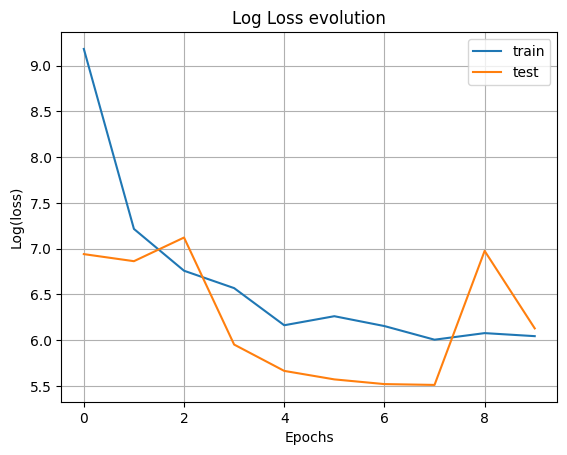

In [21]:
plt.plot(np.log(train_loss_evol), label = 'train')
plt.plot(np.log(test_loss_evol), label = 'test')
plt.legend()
plt.grid()
plt.ylabel('Log(loss)')
plt.xlabel('Epochs')
plt.title('Log Loss evolution')
